In [50]:
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_model_comparison(data_paths, model_names=None):
    '''
    data_paths: list of file paths to .pkl files, each containing performance per subject per split
    model_names: optional list of names for each model. If None, will use filename prefixes
    '''

    def collect_metric_data(subject_dict, split_name, model_name):
        df = pd.DataFrame.from_dict(subject_dict, orient='index')
        df['subject_id'] = df.index
        df['split'] = split_name
        df['model'] = model_name
        return df

    dfs = []

    for idx, path in enumerate(data_paths):
        with open(path, 'rb') as f:
            data = pickle.load(f)

        model_name = model_names[idx] if model_names else os.path.basename(path).split('/')[0]

        for split_name in ['train', 'val', 'test']:
            if split_name in data:
                dfs.append(collect_metric_data(data[split_name], split_name, model_name))

    # Combine and reshape
    all_df = pd.concat(dfs, ignore_index=True)
    melted = all_df.melt(id_vars=['subject_id', 'split', 'model'], 
                         value_vars=['bal_acc', 'f1'],
                         var_name='Metric', 
                         value_name='Score')

    # Plot
    sns.set(style='whitegrid', context='paper', font_scale=1.4)
    g = sns.catplot(
        data=melted, kind='box',
        x='Metric', y='Score', hue='model', col='split',
        palette='Set2', height=6, aspect=1
    )
    g.set_axis_labels("Metric", "Score (%)")
    g.set_titles("Split: {col_name}")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    return all_df


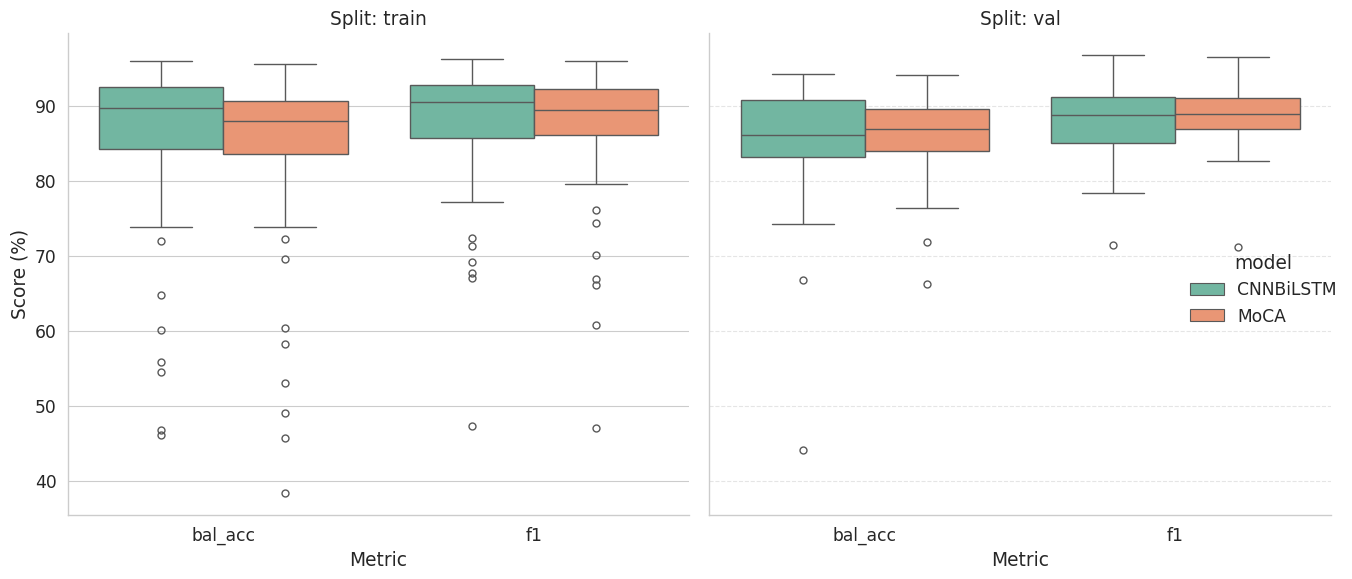

In [51]:
data_paths = [
    '/DeepPostures_MAE/MoCA/20epoch_subject_level_performance/CNNBiLSTMModel/wristset_1.0_blr_0.001_bs_512_input_size_[3, 4200]_subject_performance.pkl',
    '/DeepPostures_MAE/MoCA/20epoch_subject_level_performance/moca_shallow/wristLP_blr_0.001_bs_256_input_size_[3, 100]_subject_performance.pkl']

model_names = ['CNNBiLSTM', 'MoCA']

wrist_df = plot_model_comparison(data_paths, model_names)


In [103]:
def get_outlier_ids(df, score_column='bal_acc', id_column='subject_id',
                    model_column=None, model_value='CNNBiLSTM'):
    """
    Return a list of subject IDs whose score is an outlier based on the IQR rule,
    optionally restricted to a specific model name (default: 'CNNBiLSTM').

    Args:
        df (pd.DataFrame): Input DataFrame.
        score_column (str): Column containing the score (e.g., 'bal_acc').
        id_column (str): Column containing the subject ID.
        model_column (str, optional): Column with model names.
        model_value (str): Restrict to this model name if model_column is specified.

    Returns:
        List[str]: Unique subject IDs that are outliers.
    """
    if model_column is not None:
        df = df[df[model_column] == model_value]

    q1 = df[score_column].quantile(0.25)
    q3 = df[score_column].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = df[(df[score_column] < lower_bound) | (df[score_column] > upper_bound)]
    return outliers[id_column].unique().tolist()


In [92]:
wrist_outliers = get_outlier_ids(wrist_df)
len(wrist_outliers)


11

In [106]:
import pandas as pd

# Assuming df is your DataFrame
grouped = wrist_df.groupby(['split', 'model'])[['bal_acc', 'f1']].mean().reset_index()

print(grouped)


   split      model    bal_acc         f1
0  train  CNNBiLSTM  86.116307  88.196675
1  train       MoCA  84.251010  87.731672
2    val  CNNBiLSTM  84.057820  87.687794
3    val       MoCA  85.371662  88.034024


In [93]:
def align_top_10_worst_subjects(df):
    df_sorted = df.sort_values(by='bal_acc', ascending=True)
    model_names = df_sorted['model'].unique()

    # Get top 10 worst subject_ids per model
    worst_subjects = {}
    for model in model_names:
        worst_subjects[model] = (
            df_sorted[df_sorted['model'] == model]
            .head(10)['subject_id']
            .tolist()
        )

    # Combine all subject_ids that appear in any top-10 list
    combined_subjects = set()
    for ids in worst_subjects.values():
        combined_subjects.update(ids)

    # For each subject_id, get bal_acc for each model
    rows = []
    for sid in sorted(combined_subjects):
        row = {'subject_id': sid}
        for model in model_names:
            model_df = df_sorted[df_sorted['model'] == model]
            match = model_df[model_df['subject_id'] == sid]
            if not match.empty:
                row[f'{model}_bal_acc'] = match.iloc[0]['bal_acc']
            else:
                row[f'{model}_bal_acc'] = None
        rows.append(row)

    result_df = pd.DataFrame(rows)
    result_df.set_index('subject_id', inplace=True)
    return result_df


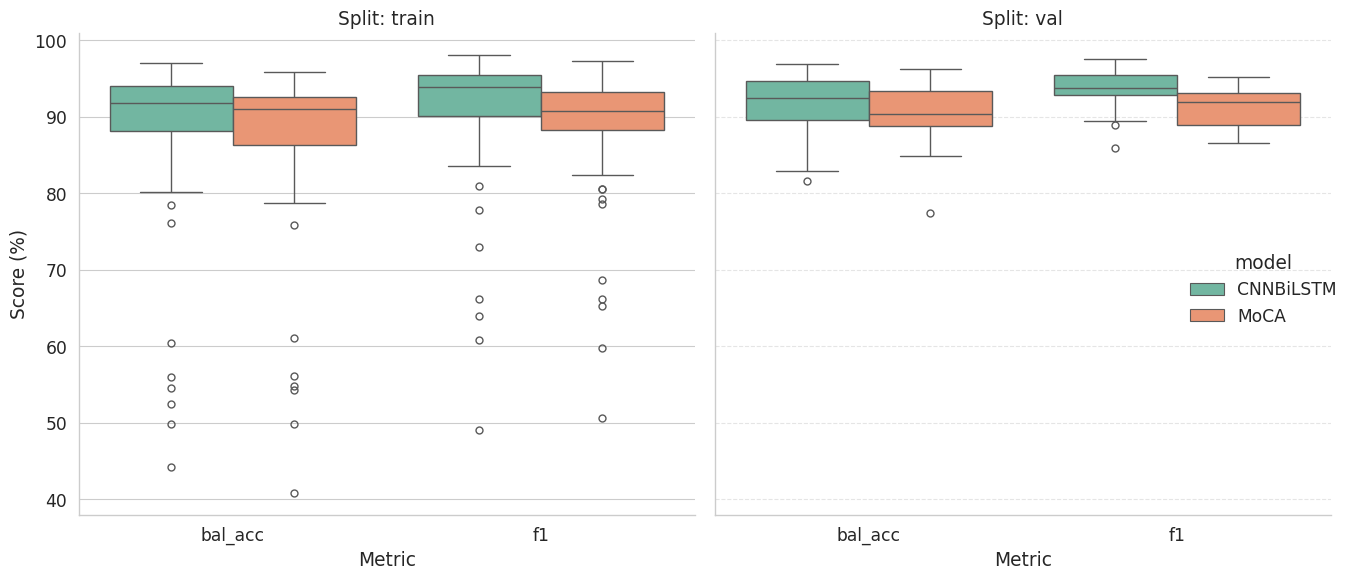

In [94]:
data_paths = [
    'subject_level_performance/CNNBiLSTMModel/hipset_1.0_blr_0.001_bs_512_input_size_[3, 4200]_subject_performance.pkl',
    'subject_level_performance/moca_shallow/hipLP_blr_0.001_bs_256_input_size_[3, 100]_subject_performance.pkl'
]

model_names = ['CNNBiLSTM', 'MoCA']

hip_df = plot_model_comparison(data_paths, model_names,)


In [95]:
wrist_outliers = get_outlier_ids(wrist_df)
print(len(wrist_outliers))
hip_outliers = get_outlier_ids(hip_df)
print(len(hip_outliers))

11
10


In [96]:
all_subject_ids = list(set(wrist_outliers + hip_outliers))
print(all_subject_ids)
print(len(all_subject_ids))

['i0195A', 'i0209A', 'i0226A', 'i0216A_1', 'i0106A', 'i0037A', 'i0093A', 'i0352A', 'i0118A_1', 'i0206A', 'i0202A', 'i0121A', 'i0091A', 'i0113A']
14


In [97]:
# get the data for these subjects from both hip and wrist dataframes and then join them


wrist_outliers_data = wrist_df[wrist_df['subject_id'].isin(all_subject_ids)]
hip_outliers_data = hip_df[hip_df['subject_id'].isin(all_subject_ids)]

# join the dataframes on subject_id
combined_outliers_data = wrist_outliers_data.merge(hip_outliers_data, on='subject_id', suffixes=('_wrist', '_hip'))
combined_outliers_data

# just get the bal_acc and model==CNNBiLSTM, finally I only need subject_id, split, CHAP-FT-bal_acc_wrist, CHAP-FT-bal_acc_hip
# keep only CNNBiLSTM entries in both wrist and hip
mask = (
    (combined_outliers_data['model_wrist'] == 'CNNBiLSTM')
    & (combined_outliers_data['model_hip'] == 'CNNBiLSTM')
)
filtered = combined_outliers_data[mask]

# select the columns you want and rename split_wrist to split
result = (
    filtered
    .loc[:, ['subject_id', 'split_wrist', 'bal_acc_wrist', 'bal_acc_hip']]
    .rename(columns={'split_wrist': 'split'})
)
result = result.reset_index(drop=True)
result['CHAP-FT-bal_acc_wrist'] = result['bal_acc_wrist']
result['CHAP-FT-bal_acc_hip'] = result['bal_acc_hip']
result = result[['subject_id', 'split', 'CHAP-FT-bal_acc_wrist', 'CHAP-FT-bal_acc_hip']]
# sort it by CHAP-FT-bal_acc_wrist
result = result.sort_values(by='CHAP-FT-bal_acc_wrist', ascending=True)
print(result)

   subject_id  split  CHAP-FT-bal_acc_wrist  CHAP-FT-bal_acc_hip
12     i0195A    val              44.047620            95.932537
0      i0037A  train              46.053337            52.396917
4      i0121A  train              46.747562            44.174027
6      i0206A  train              54.506545            49.787126
5      i0202A  train              55.792096            55.982056
3      i0113A  train              60.031784            54.470421
8      i0226A  train              64.770538            60.416901
11   i0118A_1    val              66.707572            93.296826
7    i0216A_1  train              71.994385            80.183768
13     i0209A    val              74.211201            90.643921
9      i0352A  train              78.157949            78.506464
10     i0091A    val              78.493753            82.833514
1      i0093A  train              78.884348            76.083106
2      i0106A  train              88.019991            85.392109


In [98]:
# save the result to a csv file
result.to_csv('CHAP-FT-outliers.csv', index=False)

# Find the demographic of bad subject:


### plot  i0037A for example

In [99]:
path = '/niddk-data-central/iWatch/pre_processed_pt/H/i0037A/2013-06-27.h5'
# load data and plot
import h5py
import numpy as np  

with h5py.File(path, 'r') as f:
    print("Keys in HDF5 file:", list(f.keys()))  # ['data', 'label', 'non_wear', 'sleeping', 'time']
    data = f['data'][:]
    non_wear = f['non_wear'][:]
    sleeping = f['sleeping'][:]
    timestamps = f['time'][:]
    labels = f['label'][:]
    # filter data, timestamps, and labels where not non_wear and not sleeping, directly drop these rows
    mask = (~non_wear.astype(bool)) & (~sleeping.astype(bool))
    data = data[mask]
    timestamps = timestamps[mask]
    labels = labels[mask]

print(data.shape, timestamps.shape, labels.shape)

Keys in HDF5 file: ['data', 'label', 'non_wear', 'sleeping', 'time']


KeyboardInterrupt: 

**get the model and plot it to see what's the difference between it and groud truth**

In [ ]:
from main_finetune_long import CNNBiLSTMModel,load_model_weights
model = CNNBiLSTMModel(2,42,2)

if os.path.exists("/DeepPostures_MAE/MSSE_2021_pt/pre-trained-models-pt/CHAP_ALL_ADULTS.pth"):
    transfer_learning_model_path = "/DeepPostures_MAE/MSSE_2021_pt/pre-trained-models-pt/CHAP_ALL_ADULTS.pth"
elif os.path.exists("/app/DeepPostures_MAE/MSSE_2021_pt/pre-trained-models-pt/CHAP_ALL_ADULTS.pth"):
    transfer_learning_model_path = "/app/DeepPostures_MAE/MSSE_2021_pt/pre-trained-models-pt/CHAP_ALL_ADULTS.pth"
else:
    raise FileNotFoundError("CHAP_ALL_ADULTS.pth not found in any known location.")

msg = load_model_weights(model, transfer_learning_model_path, weights_only=False)

print(msg)
model.to('cuda')

<All keys matched successfully>
Weights loaded from /DeepPostures_MAE/MSSE_2021_pt/pre-trained-models-pt/CHAP_ALL_ADULTS.pth
None


CNNBiLSTMModel(
  (cnn_model): CNNModel(
    (conv1): Conv2dSame(1, 64, kernel_size=(5, 3), stride=(2, 1))
    (conv2): Conv2dSame(64, 128, kernel_size=(5, 1), stride=(2, 1))
    (conv3): Conv2dSame(128, 256, kernel_size=(5, 1), stride=(2, 1))
    (conv4): Conv2dSame(256, 512, kernel_size=(5, 1), stride=(2, 1))
    (conv5): Conv2dSame(512, 512, kernel_size=(5, 1), stride=(2, 1))
    (fc): Linear(in_features=6144, out_features=512, bias=True)
  )
  (bil_lstm): LSTM(512, 128, batch_first=True, bidirectional=True)
  (fc_bilstm): Linear(in_features=256, out_features=1, bias=True)
)

In [ ]:
def get_model_preds(model, data, label, window_size=42):
    """
    Process data to be divisible by window_size, run model inference, and return predictions.
    Assumes model is already loaded and on the correct device.
    
    Parameters:
        model: PyTorch model, already loaded and on device
        data: numpy array, shape (N, C) or (N, window_size, C)
        window_size: int, window size to reshape data

    Returns:
        preds: numpy array, model predictions (0/1)
        processed_data: numpy array, processed input data
    """
    import torch

    num_windows = data.shape[0] // window_size
    data = data[:num_windows * window_size]
    labels = label[:num_windows * window_size]
    chap_data= torch.from_numpy(data).float().unsqueeze(1).to('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    with torch.no_grad():
        outputs = model(chap_data)
    outputs = outputs.view(-1)
    preds = torch.round(torch.sigmoid(outputs)).cpu().numpy()
    return data, preds, labels


In [ ]:
def plot_sensor_with_labels(data, labels, preds, title='Sensor Data and Labels Over Time'):
    '''
    Parameters:
        data: numpy array of shape (N, T, C) or (T, C)
        labels: numpy array of shape (N,) or (T,)
        preds: numpy array of shape (N,) or (T,)
            label and pred should be binary (0 or 1)
    '''
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import balanced_accuracy_score

    if data.ndim == 3:
        N, T, C = data.shape
        data_flat = data.reshape(-1, C)  # (N*T, C)
        labels_expanded = np.repeat(labels, T)
        preds_expanded = np.repeat(preds, T)
    elif data.ndim == 2:
        data_flat = data  # (T, C)
        labels_expanded = labels
        preds_expanded = preds
    else:
        raise ValueError("data must be 2D or 3D numpy array")

    assert len(labels_expanded) == len(data_flat), "Label length must match number of time steps"
    assert len(preds_expanded) == len(data_flat), "Pred length must match number of time steps"

    # Compute balanced accuracy
    balanced_acc = balanced_accuracy_score(labels_expanded, preds_expanded) * 100

    plt.figure(figsize=(15, 8))
    time_axis = np.arange(len(data_flat))

    for i in range(data_flat.shape[1]):
        plt.plot(time_axis, data_flat[:, i], label=f'Channel {i+1}', alpha=0.6)

    # Label regions
    label_regions = labels_expanded == 1
    plt.fill_between(time_axis, -4, 4, where=label_regions, 
                     color='red', alpha=0.1, label='Label = 1')

    # Prediction regions
    pred_regions = preds_expanded == 1
    plt.fill_between(time_axis, -4, 4, where=pred_regions, 
                     color='blue', alpha=0.1, label='Pred = 1')

    plt.xlabel('Time')
    plt.ylabel('Sensor Value')
    plt.title(f"{title} | Balanced Accuracy: {balanced_acc:.2f}%")
    plt.ylim(-4, 4)
    plt.legend()
    plt.tight_layout()
    plt.show()


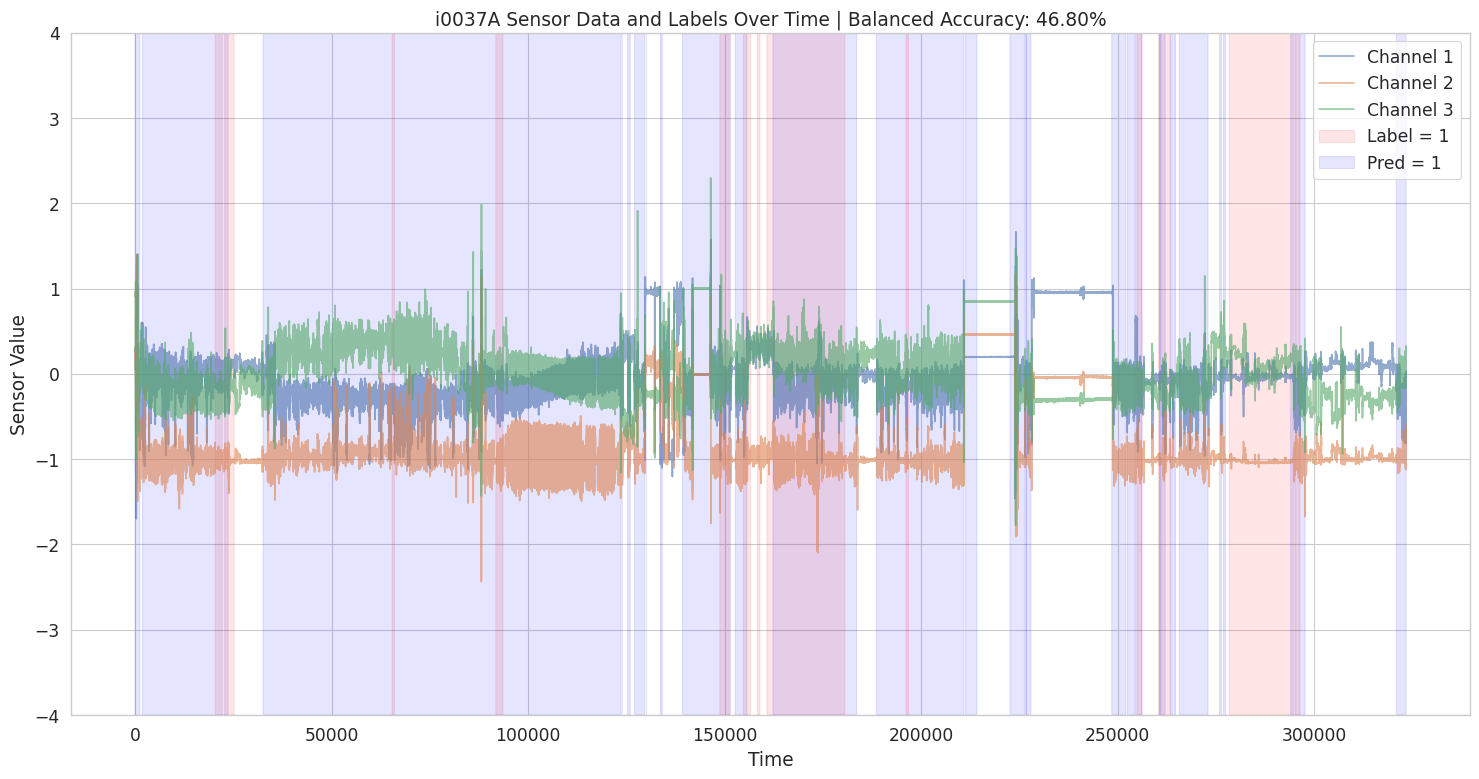

In [ ]:
data, preds,labels = get_model_preds(model, data, labels,window_size=42)
plot_sensor_with_labels(data,labels,preds, title='i0037A Sensor Data and Labels Over Time')

**wrist**

In [ ]:
path = '/niddk-data-central/iWatch/pre_processed_pt/W/i0037A/2013-06-27.h5'
# load data and plot
import h5py
import numpy as np  

with h5py.File(path, 'r') as f:
    print("Keys in HDF5 file:", list(f.keys()))  # ['data', 'label', 'non_wear', 'sleeping', 'time']
    data = f['data'][:]
    non_wear = f['non_wear'][:]
    sleeping = f['sleeping'][:]
    timestamps = f['time'][:]
    labels = f['label'][:]
    # filter data, timestamps, and labels where not non_wear and not sleeping, directly drop these rows
    mask = (~non_wear.astype(bool)) & (~sleeping.astype(bool))
    data = data[mask]
    timestamps = timestamps[mask]
    labels = labels[mask]

print(data.shape, timestamps.shape, labels.shape)

Keys in HDF5 file: ['data', 'label', 'non_wear', 'sleeping', 'time']
(4392, 100, 3) (4392,) (4392,)


/root/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


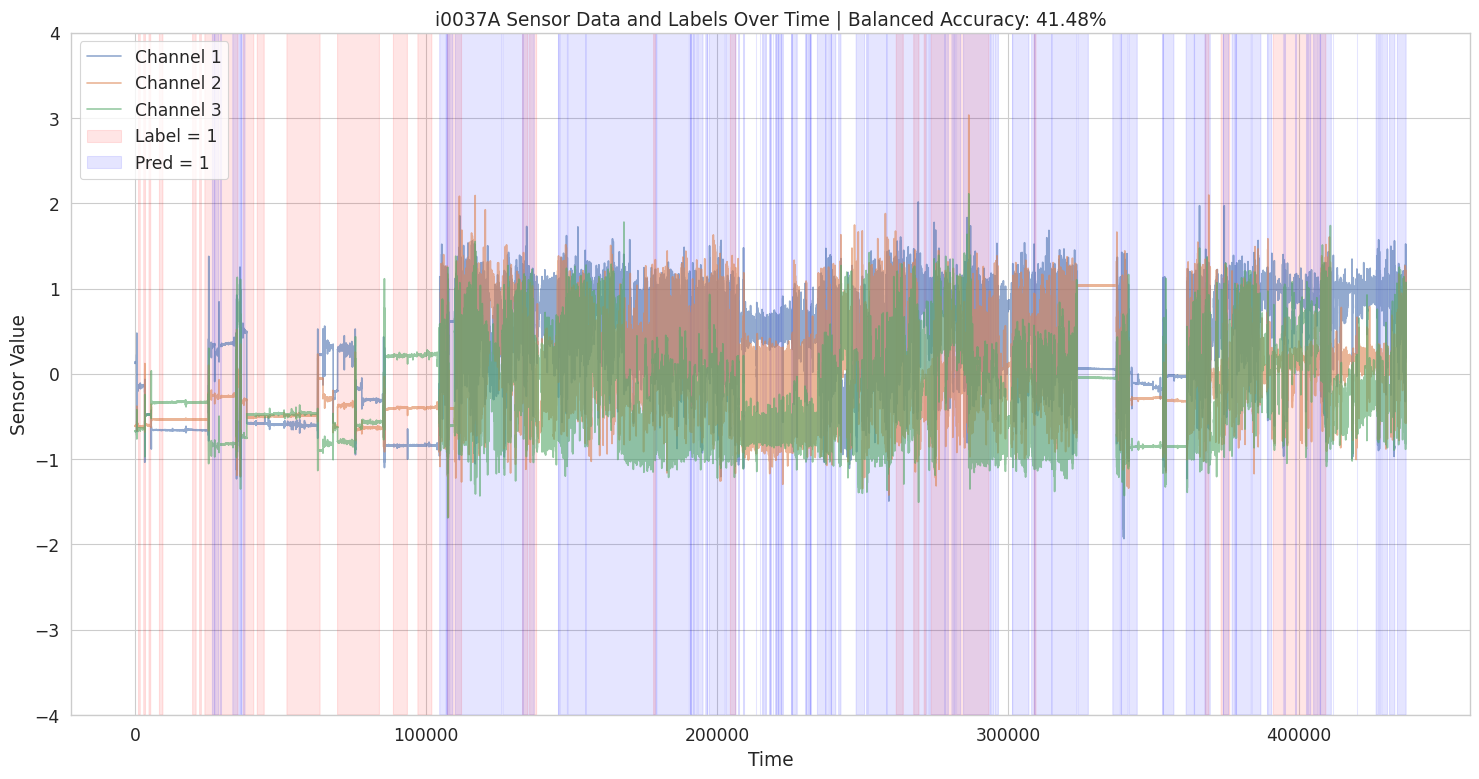

In [ ]:
data, preds,labels = get_model_preds(model, data, labels,window_size=42)
plot_sensor_with_labels(data,labels,preds, title='i0037A Sensor Data and Labels Over Time')

In [ ]:
import os

len(os.listdir('/niddk-data-central/SOL/PASOS/train/pre_processed_30hz'))

494

In [ ]:
len(os.listdir('/niddk-data-central/SOL/PASOS/train/AG_RAW'))

494

In [ ]:
import numpy as np
subject_ids = os.listdir('/niddk-data-central/SOL/PASOS/train/pre_processed_30hz')
print(subject_ids[:5])
print(len(np.unique(subject_ids)))

['C6047965', 'S8045915', 'M7092753', 'C6018941', 'S8057044']
494


In [ ]:
# do a train test split on subject_ids and then store the split in a csv file
import pandas as pd
subject_ids = os.listdir('/niddk-data-central/SOL/PASOS/train/pre_processed_30hz')
np.random.seed(42)
np.random.shuffle(subject_ids)
train_size = int(0.8 * len(subject_ids))
train_subjects = subject_ids[:train_size]
test_subjects = subject_ids[train_size:]
train_df = pd.DataFrame({'subject_id': train_subjects, 'split': 'train'})
test_df = pd.DataFrame({'subject_id': test_subjects, 'split': 'validation'})
split_df = pd.concat([train_df, test_df], ignore_index=True)
# store under /niddk-data-central/SOL/PASOS/PASOS_support_files
split_df.to_csv('/niddk-data-central/SOL/PASOS/PASOS_support_files/subject_split.csv', index=False)


In [ ]:

split_df = pd.read_csv('/niddk-data-central/SOL/PASOS/PASOS_support_files/train_val_split.csv')
train_subjects = split_df[split_df['split'] == 'train']['subject_id'].tolist()
val_subjects = split_df[split_df['split'] == 'validation']['subject_id'].tolist()

In [ ]:
print("Train subjects:", train_subjects[:5])
print("Validation subjects:", val_subjects[:5])

Train subjects: ['M7059664', 'M7020451', 'S8058462', 'M7071977', 'M7018606']
Validation subjects: ['S8085248', 'M7147175', 'M7146494', 'M7144982', 'C6059156']


In [ ]:
import os
path = '/niddk-data-central/iWatch/pre_processed_long_seg/W/10s_test.h5'

import h5py
with h5py.File(path, 'r') as f:
    print("Keys in HDF5 file:", list(f.keys()))  # ['data', 'label', 'non_wear', 'sleeping', 'time']
    print(f.keys())
    timestamps = f['timestamp'][:]
    subject_ids = f['subject_id'][:]
    

Keys in HDF5 file: ['subject_id', 'timestamp', 'x', 'y']
<KeysViewHDF5 ['subject_id', 'timestamp', 'x', 'y']>


In [ ]:
import numpy as np

indices = np.arange(i * batch_size, (i + 1) * batch_size)
repeated_indices = np.repeat(indices, 42)
print(repeated_indices.tolist())


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 

In [ ]:
import numpy as np
from datetime import datetime

# Example input (replace with your real array)
timestamps = np.array([
    [1.36731870e+09, 1.36731871e+09],
    [1.41721866e+09, 1.41721867e+09]
])

print(timestamps.shape)
# Convert to readable datetime format (vectorized)
readable_times = np.vectorize(datetime.fromtimestamp)(timestamps)

# If you want string formatting like "YYYY-MM-DD HH:MM:SS"
readable_strs = np.vectorize(lambda t: t.strftime("%Y-%m-%d %H:%M:%S"))(readable_times)

# Show result
print(readable_strs)
readable_strs.shape


(2, 2)
[['2013-04-30 10:45:00' '2013-04-30 10:45:10']
 ['2014-11-28 23:51:00' '2014-11-28 23:51:10']]


(2, 2)

In [ ]:
from MSSE_2021_pt.commons import get_dataloaders_dist

# this two dataset suppose to gives same data, help me check what's the difference
data_loader_train, data_loader_val, _ = get_dataloaders_dist(
pre_processed_dir=args.data_path,
bi_lstm_win_size=42, # chap_adult
batch_size=args.batch_size,
train_subjects=train_subjects,
valid_subjects=valid_subjects,
test_subjects=None,
rank=global_rank,
world_size=num_tasks,
transform=None,)

    dataset_train = iWatch(
        set_type='train',
        root=args.data_path,
        transform=transform,
        subset_ratio=args.subset_ratio,)
    dataset_val = iWatch(
        set_type='val',
        root=args.data_path,
        transform=None,)
    dataset_test = iWatch(
        set_type='test',
        root=args.data_path,
        transform=None,)

    print(f"using {args.subset_ratio} of train dataset, {len(dataset_train)} samples")

    if True:  # args.distributed:
        num_tasks = misc.get_world_size()
        global_rank = misc.get_rank()
        sampler_train = torch.utils.data.DistributedSampler(
            dataset_train, num_replicas=num_tasks, rank=global_rank, shuffle=True
        )
        print("Sampler_train = %s" % str(sampler_train))
    
    data_loader_train = torch.utils.data.DataLoader(
        dataset_train, sampler=sampler_train,
        batch_size=args.batch_size,
        num_workers=args.num_workers,
        pin_memory=args.pin_mem,
        drop_last=True,
    )

    data_loader_val = torch.utils.data.DataLoader(
        dataset_val, 
        batch_size=args.batch_size,
        num_workers=args.num_workers,
        pin_memory=args.pin_mem,
        drop_last=False, 
        shuffle=False,
    )

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test,
        batch_size=args.batch_size,
        num_workers=args.num_workers,
        pin_memory=args.pin_mem,
        drop_last=False,
        shuffle=False,  )


In [ ]:
long_seg_path = '/niddk-data-central/iWatch/pre_processed_long_seg/W/10s_val.h5'
# load and count total number of samples
import h5py
with h5py.File(long_seg_path, 'r') as f:
    print("Keys in HDF5 file:", list(f.keys()))  # ['data', 'label', 'non_wear', 'sleeping', 'time']
    data = f['x'][:]



Keys in HDF5 file: ['subject_id', 'timestamp', 'x', 'y']


In [ ]:
data.shape

(9626, 42, 100, 3)

In [ ]:
import sys
import os
import pickle
import util.misc as misc
if os.path.exists('/DeepPostures_MAE/MSSE_2021_pt'):
    sys.path.append('/DeepPostures_MAE/MSSE_2021_pt')
elif os.path.exists('/app/DeepPostures_MAE/MSSE_2021_pt'):
    sys.path.append('/app/DeepPostures_MAE/MSSE_2021_pt')
else:
    raise FileNotFoundError("MSSE_2021_pt directory not found.")

with open("/niddk-data-central/iWatch/support_files/iwatch_split_dict.pkl", "rb") as f:
    split_data = pickle.load(f)

train_subjects = split_data["train"]
valid_subjects = split_data["val"]

num_tasks = misc.get_world_size()
global_rank = misc.get_rank()

path  = '/niddk-data-central/iWatch/pre_processed_pt/W'
from commons import get_dataloaders_dist
data_loader_train, data_loader_val, _ = get_dataloaders_dist(
pre_processed_dir=path,
bi_lstm_win_size=42, # chap_adult
batch_size=12,
train_subjects=train_subjects,
valid_subjects=valid_subjects,
test_subjects=None,
rank=global_rank,
world_size=num_tasks,
transform=None,)

# iterate through the data loader and stack all the data to check the shape
import torch
data_list = []
for i, batch in enumerate(data_loader_val):
    # print(batch)
    # print(batch[0].shape)
    data_list.append(batch[0])


  0%|          | 0/21 [00:00<?, ?it/s]

100%|██████████| 21/21 [00:24<00:00,  1.15s/it]


In [ ]:
# stack the data_list at first dimension, (n1,...), (n2,...) -> (n1+n2,...)
data_stacked = torch.cat(data_list, dim=0)
print(data_stacked.shape)

torch.Size([9626, 42, 100, 3])
